<a href="https://colab.research.google.com/github/AbVishwas/AbVishwas/blob/main/HFM_abhijeet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Fluid Mechanics for 2D Shallow Water Equations

Utilization of physics informed neural network to solve non-conserved 2D shallow water equations.

The shallow-water equations are a set of hyperbolic partial differential equations that describe the flow below a pressure surface in a fluid.
The equations are derived from depth-integrating the Navier–Stokes equations, in the case where the horizontal length scale is much greater than the vertical length scale.

Applications:
1.   Tsunami prediction
2.   Atmospheric flow
3.   Storm surges
1.   Planetary Flows

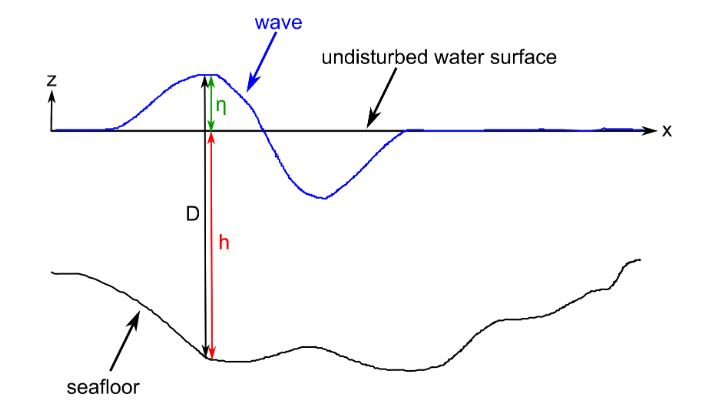

For simplicity, we will consider the seabed to be flat and uniform evreywhere. η is the amplitude of wave at the corresponding position. Where h is the mean height.

It is often the case that the terms quadratic in u and v, which represent the effect of bulk advection, are small compared to the other terms. This is called geostrophic balance, and is equivalent to saying that the Rossby number is small. Assuming also that the wave height is very small compared to the mean height (h ≪ H), we have (without lateral viscous forces)

These conservative shallow water equations are solved by [jostbr](https://https://github.com/jostbr/shallow-water).


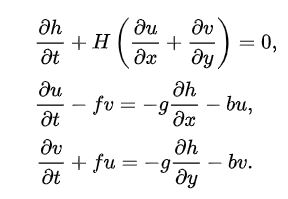

For Physics Informed Neural Network to solve 2D shallow water equation we will use a fully connected network, which will take input of spatiotemporal co-ordinates (x, y, t) and will output (η , u, v) are the outputs. More information regarding the PINN and hidden fluid mechanics neural netork can be found [here](https://https://github.com/maziarraissi/PINNs) and [here](https://github.com/maziarraissi/HFM).

We will add a small code snippet to the swe.py which will enable us to store the relevant data in .csv format.

In [ ]:
import pandas as pd

U = np.array(u_list).reshape(250,-1).T                          # to flatten the 2D field and get the format (Time steps, velocity)
V = np.array(v_list).reshape(250, -1).T                         # to flatten the 2D field and get the format (Time steps, velocity)
ETA = np.array(eta_list).reshape(250, -1).T                     # to flatten the 2D field and get the format (Time steps, height)

t  = np.linspace(0,249,250)

X_star, Y_star, T_star = np.meshgrid(x, y, t)                   # create a meshgrid of the input parameters

dataset = np.hstack((X_star.flatten()[:,None], Y_star.flatten()[:,None], T_star.flatten()[:,None],ETA.flatten()[:,None], U.flatten()[:,None], V.flatten()[:,None]))
data_out = np.hstack(( ETA, U, V))

pd.DataFrame(dataset).to_csv("./dataset.csv")
pd.DataFrame(data_out).to_csv("./data_out.csv")

NameError: ignored

# Training and Test Datasets

Now as we have all the relevant data, we will start constructing our physics informed neural network with the training and test data sets

In [1]:
# ===========================================================================
# Initiate and Import Liabraries
# =============================================================================

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd 
import time
import sys

tf.compat.v1.disable_eager_execution() 

print("TensorFlow version: {}".format(tf.__version__))                         # Print the tf version
print("Eager execution: {}".format(tf.executing_eagerly()))                    # Check if Eager Execution is on
print("devices: {}".format(tf.config.list_physical_devices('GPU')))   



TensorFlow version: 2.8.0
Eager execution: False
devices: []


In [6]:
#==============================================================================
#Import dataset and prepare training, test datasets
#==============================================================================

dataset = "/content/dataset.csv"                                                           
dataset = np.array(pd.read_csv(dataset, header = None))[1:, 1:]


x = dataset[:,0].reshape(-1,1)                           # extract data from .csv file and reshape (n,) into (n , 1)
y = dataset[:,1].reshape(-1,1)                          # extract data from .csv file and reshape (n,) into (n , 1)
t = dataset[:,2].reshape(-1,1)                          # extract data from .csv file and reshape (n,) into (n , 1)
eta = dataset[:,3].reshape(-1,1)                          # extract data from .csv file and reshape (n,) into (n , 1)
u = dataset[:,4].reshape(-1,1)                          # extract data from .csv file and reshape (n,) into (n , 1)
v = dataset[:,5].reshape(-1,1)                          # extract data from .csv file and reshape (n,) into (n , 1)


idx_d = np.random.choice(dataset.shape[0], size = 30000, replace = False)  
# select random indices from the dataset to prepare the training dataset
x_data = x[idx_d]
y_data = y[idx_d ]
t_data = t[idx_d]

eta_data = eta[idx_d]
u_data =    u[idx_d]
v_data =    v[idx_d]

idx_e = np.random.choice(dataset.shape[0], size = 30000, replace = False)
# select random indices from the dataset to prepare the collocation dataset (for equations)

x_eqns = x[idx_e]
y_eqns = y[idx_e]
t_eqns = t[idx_e]

eta_eqns = eta[idx_e ]
u_eqns = u[idx_e ]
v_eqns = v[idx_e]

idx_d_test = np.random.choice(dataset.shape[0], size = 300, replace = False)
# select random indices from the dataset to prepare the testing dataset

t_test = t[idx_d_test]
x_test = x[idx_d_test]
y_test = y[idx_d_test]

eta_test = eta[idx_d_test]
u_test = u[idx_d_test]
v_test = v[idx_d_test]

# The Neural Network

In [7]:
#%% ===========================================================================
# Buid the Neural Network class and other important fnctions
# This classes were originally written in tensorflow 1.x by Raissi et.al.
# But necessary changes have been made to run them in Tensorflow 2.7.0
# =============================================================================
def tf_session():
    # tf session
    config = tf.compat.v1.ConfigProto(allow_soft_placement=True,
                            log_device_placement=True)
    config.gpu_options.force_gpu_compatible = True
    sess = tf.compat.v1.Session(config=config)
    
    # init
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    
    return sess

def relative_error(pred, exact):             # Function to calculate the norm of rms error during testing
    if type(pred) is np.ndarray:
        return np.sqrt(np.mean(np.square(pred - exact))/np.mean(np.square(exact - np.mean(exact))))
    return tf.sqrt(tf.reduce_mean(tf.square(pred - exact))/tf.reduce_mean(tf.square(exact - tf.reduce_mean(exact))))

def mean_squared_error(pred, exact):       # Function to calculate the MSE error during training 
    if type(pred) is np.ndarray:
        return np.mean(np.square(pred - exact))
    return tf.reduce_mean(tf.square(pred - exact))

def fwd_gradients(Y, x):               # Function to compute forward gradients for the equations 
    dummy = tf.ones_like(Y)
    G = tf.compat.v1.gradients(Y, x, grad_ys=dummy, colocate_gradients_with_ops=True)[0]
    Y_x = tf.compat.v1.gradients(G, dummy, colocate_gradients_with_ops=True)[0]
    return Y_x


class neural_net(object):         # NN class for fully connected network
    def __init__(self, *inputs, layers):
        
        self.layers = layers
        self.num_layers = len(self.layers)
        
        if len(inputs) == 0:
            in_dim = self.layers[0]
            self.X_mean = np.zeros([1, in_dim])
            self.X_std = np.ones([1, in_dim])
        else:
            X = np.concatenate(inputs, 1)
            self.X_mean = X.mean(0, keepdims=True)
            self.X_std = X.std(0, keepdims=True)
        
        self.weights = []                  #Initialize weights and biases
        self.biases = []
        self.gammas = []
        
        for l in range(0,self.num_layers-1):
            in_dim = self.layers[l]
            out_dim = self.layers[l+1]
            W = np.random.normal(size=[in_dim, out_dim])
            b = np.zeros([1, out_dim])
            g = np.ones([1, out_dim])
            # tensorflow variables
            self.weights.append(tf.Variable(W, dtype=tf.float32, trainable=True))
            self.biases.append(tf.Variable(b, dtype=tf.float32, trainable=True))
            self.gammas.append(tf.Variable(g, dtype=tf.float32, trainable=True))
            
    def __call__(self, *inputs):
                
        H = (tf.concat(inputs, 1) - self.X_mean)/self.X_std
    
        for l in range(0, self.num_layers-1):
            W = self.weights[l]
            b = self.biases[l]
            g = self.gammas[l]
            # weight normalization
            V = W/tf.norm(W, axis = 0, keepdims=True)
            # matrix multiplication
            H = tf.matmul(H, V)
            # add bias
            H = g*H + b
            # activation
            if l < self.num_layers-2:
                H = H*tf.sigmoid(H)
                
        Y = tf.split(H, num_or_size_splits=H.shape[1], axis=1)
    
        return Y

def shallow_water_2D(eta, u, v, t, x, y, H, f):
    
    Y = tf.concat([eta, u, v], 1)
    
    Y_t = fwd_gradients(Y, t)
    Y_x = fwd_gradients(Y, x)
    Y_y = fwd_gradients(Y, y)

    u = Y[:,1:2]
    v = Y[:,2:3]
    
    eta_t = Y_t[:,0:1]
    u_t = Y_t[:,1:2]
    v_t = Y_t[:,2:3]
    v_y = Y_y[:,2:3]
    
    eta_x = Y_x[:,0:1]
    u_x = Y_x[:,1:2]

    eta_y = Y_y[:,0:1]

    g= 9.81

    e1 = eta_t + H*(u_x + v_y)               #2D Shallow water equations 
    e2 = u_t - f*v + g*eta_x 
    e3 = v_t + f*u + g*eta_y
    
    return e1, e2, e3



# The PINN

In [8]:
#%% ===========================================================================
# Buid the HFM-Physics Informed Neural Network
# =============================================================================

class HFM(object):
    # notational conventions
    # _tf: placeholders for input/output data and points used to regress the equations
    # _pred: output of neural network
    # _eqns: points used to regress the equations
    # _data: input-output data
    # _inlet: input-output data at the inlet
    # _star: preditions
    
    def __init__(self, t_data, x_data, y_data, eta_data,
                       t_eqns, x_eqns, y_eqns,
                       layers, batch_size,
                       H, f):
        
        # specs
        self.layers = layers
        self.batch_size = batch_size
        
        # flow properties
        self.H = H        # mean height from seabed
        self.f = f        # friction coefficient 
        
        # data
        [self.t_data, self.x_data, self.y_data, self.eta_data] = [t_data, x_data, y_data, eta_data]
        
        [self.t_eqns, self.x_eqns, self.y_eqns] = [t_eqns, x_eqns, y_eqns]
     
        # placeholders
        [self.t_data_tf, self.x_data_tf, self.y_data_tf, self.eta_data_tf] = [tf.compat.v1.placeholder(tf.float32, shape=[None, 1]) for _ in range(4)]
        [self.t_eqns_tf, self.x_eqns_tf, self.y_eqns_tf] = [tf.compat.v1.placeholder(tf.float32, shape=[None, 1]) for _ in range(3)]
        
        # physics "uninformed" neural networks
        self.net_cuvp = neural_net(self.t_data, self.x_data, self.y_data, layers = self.layers)
        
        [self.eta_data_pred,
          self.u_data_pred,
          self.v_data_pred,] = self.net_cuvp(self.t_data_tf,                                    #self.u_data_pred
                               self.x_data_tf,
                               self.y_data_tf)
        
        # physics "informed" neural networks
        [self.eta_eqns_pred,
         self.u_eqns_pred,
         self.v_eqns_pred,] = self.net_cuvp(self.t_eqns_tf,                                       #self.u_eqns_pred
                              self.x_eqns_tf,
                              self.y_eqns_tf)
        
        [self.e1_eqns_pred,
         self.e2_eqns_pred,
         self.e3_eqns_pred] = shallow_water_2D(self.eta_eqns_pred,
                                               self.u_eqns_pred,
                                               self.v_eqns_pred,
                                               self.t_eqns_tf,
                                               self.x_eqns_tf,
                                               self.y_eqns_tf,
                                               self.f,
                                               self.H)
         
        # loss
        self.loss = mean_squared_error(self.eta_data_pred, self.eta_data_tf) + \
                    mean_squared_error(self.e1_eqns_pred, 0.0) + \
                    mean_squared_error(self.e2_eqns_pred, 0.0) + \
                    mean_squared_error(self.e3_eqns_pred, 0.0) 
        
        # optimizers
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])
        self.optimizer = tf.compat.v1.train.AdamOptimizer()
        self.train_op = self.optimizer.minimize(self.loss)    
        self.sess = tf_session()
    
    def train(self, total_time, learning_rate):
        
        N_data = self.t_data.shape[0]
        N_eqns = self.t_eqns.shape[0]
        
        start_time = time.time()
        running_time = 0
        it = 0
        while running_time < total_time:
            
            idx_data = np.random.choice(N_data, min(self.batch_size, N_data))
            idx_eqns = np.random.choice(N_eqns, self.batch_size)
            
            (t_data_batch,
             x_data_batch,
             y_data_batch,
             eta_data_batch) = (self.t_data[idx_data,:],
                              self.x_data[idx_data,:],
                              self.y_data[idx_data,:],
                              self.eta_data[idx_data,:])

            (t_eqns_batch,
             x_eqns_batch,
             y_eqns_batch) = (self.t_eqns[idx_eqns,:],
                              self.x_eqns[idx_eqns,:],
                              self.y_eqns[idx_eqns,:])


            tf_dict = {self.t_data_tf: t_data_batch,
                       self.x_data_tf: x_data_batch,
                       self.y_data_tf: y_data_batch,
                       self.eta_data_tf: eta_data_batch,
                       self.t_eqns_tf: t_eqns_batch,
                       self.x_eqns_tf: x_eqns_batch,
                       self.y_eqns_tf: y_eqns_batch,
                       self.learning_rate: learning_rate}
            
            self.sess.run([self.train_op], tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                running_time += elapsed/3600.0
                [loss_value,
                 learning_rate_value] = self.sess.run([self.loss,
                                                       self.learning_rate], tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2fs, Running Time: %.2fh, Learning Rate: %.1e'
                      %(it, loss_value, elapsed, running_time, learning_rate_value))
                sys.stdout.flush()
                start_time = time.time()
            it += 1
    
    def predict(self, t_star, x_star, y_star):
        
        tf_dict = {self.t_data_tf: t_star, self.x_data_tf: x_star, self.y_data_tf: y_star}
        
        eta_star = self.sess.run(self.eta_data_pred, tf_dict)
        u_star = self.sess.run(self.u_data_pred, tf_dict)
        v_star = self.sess.run(self.v_data_pred, tf_dict)
       
        return eta_star, u_star, v_star


# Train, Test, Plot

Device mapping: no known devices.
It: 0, Loss: 3.281e-01, Time: 3.68s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 10, Loss: 2.717e-02, Time: 2.24s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 20, Loss: 2.652e-02, Time: 2.24s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 30, Loss: 1.160e-02, Time: 2.21s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 40, Loss: 5.197e-03, Time: 2.22s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 50, Loss: 3.905e-03, Time: 2.20s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 60, Loss: 3.492e-03, Time: 2.20s, Running Time: 0.00h, Learning Rate: 1.0e-03
It: 70, Loss: 3.530e-03, Time: 2.15s, Running Time: 0.01h, Learning Rate: 1.0e-03
It: 80, Loss: 3.110e-03, Time: 2.19s, Running Time: 0.01h, Learning Rate: 1.0e-03
It: 90, Loss: 3.222e-03, Time: 2.19s, Running Time: 0.01h, Learning Rate: 1.0e-03
It: 100, Loss: 3.187e-03, Time: 2.23s, Running Time: 0.01h, Learning Rate: 1.0e-03
It: 110, Loss: 3.206e-03, Time: 2.22s, Running Time: 0.01h, Lear

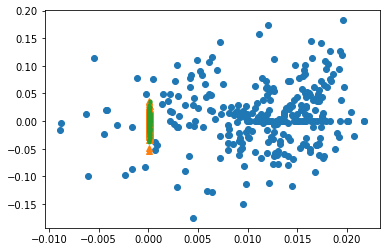

In [9]:
#%% ===========================================================================
# Train and Test the Neural Network 
# =============================================================================

batch_size = 10000
layers = [3] + 10*[4*10] + [3]

# Training
model = HFM(t_data, x_data, y_data, eta_data,
            t_eqns, x_eqns, y_eqns,
            layers, batch_size,
            H = 100, f = 1e-4)

model.train(total_time = 0.1, learning_rate=1e-3)


# Prediction
eta_pred, u_pred, v_pred = model.predict(t_test, x_test, y_test)

# Error
error_eta = relative_error(eta_pred, eta_test)
error_u = relative_error(u_pred, u_test)
error_v = relative_error(v_pred, v_test)


print('Error eta: %e' % (error_eta)) # Calculating the norm the MSE error
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))

#plot
plt.plot(eta_pred, eta_test,'o')  # Plot Pred vs Test
plt.plot(u_pred, u_test,'^')      # Supposed to be a straight line (@45 degrees)
plt.plot(v_pred, v_test,'.')      # The deviation angle will give the idea of the error 
